In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset
ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')
dataset_all, info = tfds.load('ag_news_subset', with_info=True,  split=ri, as_supervised=True)

2021-08-27 04:32:19.889583: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-27 04:32:20.537591: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-27 04:32:20.538721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
I0827 04:32:20.539829 139958931593088 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
2021-08-27 04:32:20.549199: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-08-27 04

In [ ]:
fig = px.histogram(comp_df, x='Words_clipped', template='plotly_white', title='Complain counts by length')
fig.update_xaxes(categoryorder='total descending', title='Number of words (clipped at 1000 words)').update_yaxes(title='Number of complaints')
fig.show()

Text(0.5, 0, 'Percent of Non-Vocabulary Words in a Document')

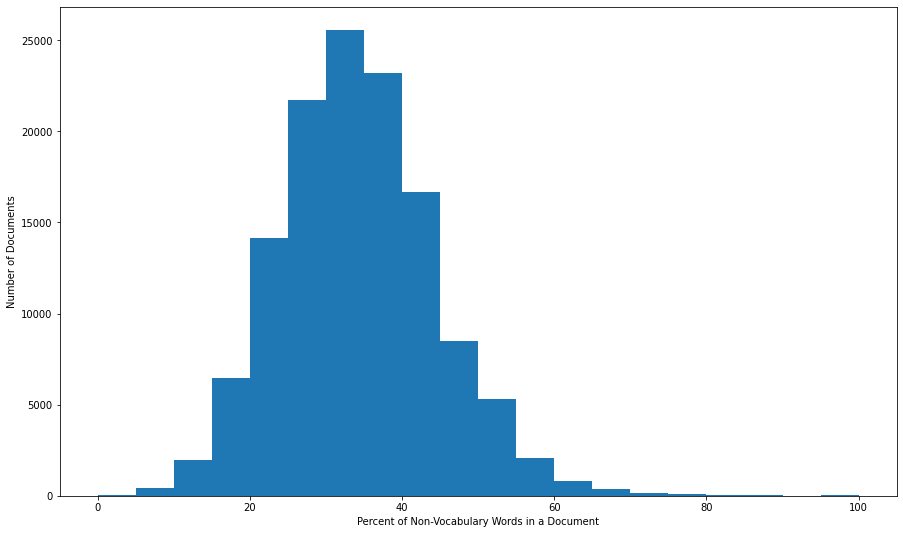

In [ ]:
plt.figure(figsize=(15,9))
plt.hist(percents, 20)
plt.ylabel('Number of Documents')
plt.xlabel('Percent of Non-Vocabulary Words in a Document')

In [2]:
tfds.as_dataframe(dataset_all.take(10),info)

,description,label
0,"AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.",3 (Sci/Tech)
1,Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.,1 (Sports)
2,"President Bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2 (Business)
3,"Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.",3 (Sci/Tech)
4,"London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.",1 (Sports)
5,TOKYO - Sony Corp. is banking on the \$3 billion deal to acquire Hollywood studio Metro-Goldwyn-Mayer Inc...,0 (World)
6,"Giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in China in their efforts to protect the engandered animals living in the remote Wolong Nature Reserve.",3 (Sci/Tech)
7,"VILNIUS, Lithuania - Lithuania #39;s main parties formed an alliance to try to keep a Russian-born tycoon and his populist promises out of the government in Sunday #39;s second round of parliamentary elections in this Baltic country.",0 (World)
8,Witnesses in the trial of a US soldier charged with abusing prisoners at Abu Ghraib have told the court that the CIA sometimes directed abuse and orders were received from military command to toughen interrogations.,0 (World)
9,"Dan Olsen of Ponte Vedra Beach, Fla., shot a 7-under 65 Thursday to take a one-shot lead after two rounds of the PGA Tour qualifying tournament.",1 (Sports)


In [ ]:
%%time
encoder_1000 = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=1000)
encoder_1000.adapt(dataset_all.map(lambda text, label: text))
vocab_1000 = np.array(encoder_1000.get_vocabulary());

Cause: could not parse the source code of <function <lambda> at 0x7fc0571e3290>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fc0571e3290>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fc0571e3290>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 7min 31s, sys: 2min 7s, total: 9min 39s
Wall time: 3min 19s


In [ ]:
%%time
doc1000_sizes = []
corpus1000 = []
count1000=0
useless = 0
percents = []
for example, _ in dataset_all.as_numpy_iterator():
  enc_example = encoder_1000(example)
  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
  percent_ones = round(num_ones*100/len(enc_example))
  percents.append(percent_ones)
  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1
  doc1000_sizes.append(len(enc_example))
  corpus1000+=list(enc_example.numpy())
  count1000 += tf.math.count_nonzero(enc_example>1)

CPU times: user 18min 3s, sys: 2min 24s, total: 20min 28s
Wall time: 16min 45s


In [ ]:
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset
dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test[:]'], as_supervised=True)
train_dataset, validation_dataset, test_dataset = dataset

2021-08-23 08:22:24.930940: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-23 08:22:24.940166: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-23 08:22:24.941041: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
I0823 08:22:24.941896 140158424983424 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
I0823 08:22:24.942641 140158424983424 dataset_info.py:361] Load dataset info from /root/tensorflow_datasets/ag_news_subset/1.0.0
I0823 08:22:24.944212 140158424983424 download_and_prepare.py:138] download_and_prep

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
model = tf.keras.Sequential([
encoder
,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
,output_dim=64
,mask_zero=True)
,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
,tf.keras.layers.Dense(64, activation='relu')
,tf.keras.layers.Dense(4,activation='softmax')])
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [ ]:
%%time
history = model.fit(train_dataset ,epochs = 250 ,validation_data=validation_dataset ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)])

Epoch 1/250
1782/1782 [==============================] - 41s 17ms/step - loss: 0.7068 - accuracy: 0.7402 - val_loss: 0.4811 - val_accuracy: 0.8347
Epoch 2/250
1782/1782 [==============================] - 28s 16ms/step - loss: 0.4634 - accuracy: 0.8333 - val_loss: 0.4474 - val_accuracy: 0.8447
Epoch 3/250
1782/1782 [==============================] - 28s 16ms/step - loss: 0.4381 - accuracy: 0.8425 - val_loss: 0.4273 - val_accuracy: 0.8507
Epoch 4/250
1782/1782 [==============================] - 28s 16ms/step - loss: 0.4151 - accuracy: 0.8508 - val_loss: 0.4132 - val_accuracy: 0.8547
Epoch 5/250
1782/1782 [==============================] - 28s 16ms/step - loss: 0.3979 - accuracy: 0.8564 - val_loss: 0.3979 - val_accuracy: 0.8588
Epoch 6/250
1782/1782 [==============================] - 28s 16ms/step - loss: 0.3883 - accuracy: 0.8587 - val_loss: 0.3976 - val_accuracy: 0.8585
Epoch 7/250
1782/1782 [==============================] - 28s 16ms/step - loss: 0.3820 - accuracy: 0.8606 - val_loss: 0

In [ ]:
model = tf.keras.Sequential([encoder,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True)
,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True))
,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
,tf.keras.layers.Dense(64, activation='relu')
,tf.keras.layers.Dense(4,activation='softmax')])
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [ ]:
%%time
history = model.fit(train_dataset ,epochs = 250 ,validation_data=validation_dataset ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)])

Epoch 1/250
1782/1782 [==============================] - 69s 31ms/step - loss: 0.6064 - accuracy: 0.7687 - val_loss: 0.4392 - val_accuracy: 0.8455
Epoch 2/250
1782/1782 [==============================] - 50s 28ms/step - loss: 0.4179 - accuracy: 0.8505 - val_loss: 0.4183 - val_accuracy: 0.8530
Epoch 3/250
1782/1782 [==============================] - 50s 28ms/step - loss: 0.3947 - accuracy: 0.8570 - val_loss: 0.3897 - val_accuracy: 0.8632
Epoch 4/250
1782/1782 [==============================] - 50s 28ms/step - loss: 0.3852 - accuracy: 0.8607 - val_loss: 0.3901 - val_accuracy: 0.8642
Epoch 5/250
1782/1782 [==============================] - 50s 28ms/step - loss: 0.3788 - accuracy: 0.8624 - val_loss: 0.3875 - val_accuracy: 0.8607
Epoch 6/250
1782/1782 [==============================] - 50s 28ms/step - loss: 0.3736 - accuracy: 0.8637 - val_loss: 0.3807 - val_accuracy: 0.8647
Epoch 7/250
1782/1782 [==============================] - 50s 28ms/step - loss: 0.3684 - accuracy: 0.8659 - val_loss: 0

In [ ]:
%%time
encoder_2000 = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=2000)
encoder_2000.adapt(dataset_all.map(lambda text, label: text))
vocab_2000 = np.array(encoder_2000.get_vocabulary());

Cause: could not parse the source code of <function <lambda> at 0x7fbfdfb50b90>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fbfdfb50b90>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fbfdfb50b90>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 6min 54s, sys: 1min 58s, total: 8min 53s
Wall time: 3min 17s


In [ ]:
%%time
doc2000_sizes = []
corpus2000 = []
count2000=0
useless = 0
percents = []
for example, _ in dataset_all.as_numpy_iterator():
  enc_example = encoder_2000(example)
  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
  percent_ones = round(num_ones*100/len(enc_example))
  percents.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1

  doc2000_sizes.append(len(enc_example))
  corpus2000+=list(enc_example.numpy())

  count2000 += tf.math.count_nonzero(enc_example>1)

CPU times: user 18min 34s, sys: 2min 19s, total: 20min 53s
Wall time: 17min 7s


In [ ]:
model2 = tf.keras.Sequential([
encoder
,tf.keras.layers.Embedding(input_dim=len(encoder_2000.get_vocabulary())
,output_dim=64
,mask_zero=True)
,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
,tf.keras.layers.Dense(64, activation='relu')
,tf.keras.layers.Dense(4,activation='softmax')])
model2.compile(optimizer=tf.keras.optimizers.Adam(1e-4),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [ ]:
%%time
history2 = model2.fit(train_dataset ,epochs = 250 ,validation_data=validation_dataset ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)])

Epoch 1/250
1782/1782 [==============================] - 39s 18ms/step - loss: 0.7455 - accuracy: 0.7194 - val_loss: 0.4996 - val_accuracy: 0.8257
Epoch 2/250
1782/1782 [==============================] - 29s 16ms/step - loss: 0.4565 - accuracy: 0.8408 - val_loss: 0.4509 - val_accuracy: 0.8430
Epoch 3/250
1782/1782 [==============================] - 29s 16ms/step - loss: 0.4126 - accuracy: 0.8527 - val_loss: 0.4219 - val_accuracy: 0.8500
Epoch 4/250
1782/1782 [==============================] - 29s 16ms/step - loss: 0.3961 - accuracy: 0.8580 - val_loss: 0.4037 - val_accuracy: 0.8540
Epoch 5/250
1782/1782 [==============================] - 29s 16ms/step - loss: 0.3876 - accuracy: 0.8591 - val_loss: 0.3918 - val_accuracy: 0.8628
Epoch 6/250
1782/1782 [==============================] - 29s 16ms/step - loss: 0.3824 - accuracy: 0.8615 - val_loss: 0.3813 - val_accuracy: 0.8648
Epoch 7/250
1782/1782 [==============================] - 29s 16ms/step - loss: 0.3780 - accuracy: 0.8622 - val_loss: 0

In [ ]:
model2 = tf.keras.Sequential([
encoder
,tf.keras.layers.Embedding(input_dim=len(encoder_2000.get_vocabulary())
,output_dim=64
,mask_zero=True)
,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True))
,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
,tf.keras.layers.Dense(64, activation='relu')
,tf.keras.layers.Dense(4,activation='softmax')])
model2.compile(optimizer=tf.keras.optimizers.Adam(1e-4),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [ ]:
%%time
history2 = model2.fit(train_dataset ,epochs = 250 ,validation_data=validation_dataset ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)])

Epoch 1/250
1782/1782 [==============================] - 67s 30ms/step - loss: 0.6744 - accuracy: 0.7284 - val_loss: 0.4624 - val_accuracy: 0.8412
Epoch 2/250
1782/1782 [==============================] - 48s 27ms/step - loss: 0.4391 - accuracy: 0.8426 - val_loss: 0.4147 - val_accuracy: 0.8555
Epoch 3/250
1782/1782 [==============================] - 49s 27ms/step - loss: 0.4058 - accuracy: 0.8542 - val_loss: 0.4043 - val_accuracy: 0.8535
Epoch 4/250
1782/1782 [==============================] - 48s 27ms/step - loss: 0.3914 - accuracy: 0.8590 - val_loss: 0.4077 - val_accuracy: 0.8545
Epoch 5/250
1782/1782 [==============================] - 48s 27ms/step - loss: 0.3815 - accuracy: 0.8616 - val_loss: 0.3839 - val_accuracy: 0.8628
Epoch 6/250
1782/1782 [==============================] - 49s 27ms/step - loss: 0.3746 - accuracy: 0.8638 - val_loss: 0.3869 - val_accuracy: 0.8618
Epoch 7/250
1782/1782 [==============================] - 48s 27ms/step - loss: 0.3701 - accuracy: 0.8652 - val_loss: 0

In [ ]:
%%time
encoder_3000 = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=2000)
encoder_3000.adapt(dataset_all.map(lambda text, label: text))
vocab_3000 = np.array(encoder_3000.get_vocabulary());

Cause: could not parse the source code of <function <lambda> at 0x7fbfc808f560>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fbfc808f560>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fbfc808f560>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 6min 20s, sys: 1min 59s, total: 8min 20s
Wall time: 3min 5s


In [ ]:
%%time
doc3000_sizes = []
corpus3000 = []
count3000=0
useless = 0
percents = []
for example, _ in dataset_all.as_numpy_iterator():
  enc_example = encoder_3000(example)
  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
  percent_ones = round(num_ones*100/len(enc_example))
  percents.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1

  doc3000_sizes.append(len(enc_example))
  corpus3000+=list(enc_example.numpy())

  count3000 += tf.math.count_nonzero(enc_example>1)

CPU times: user 17min 53s, sys: 2min 25s, total: 20min 18s
Wall time: 16min 40s


In [ ]:
model3 = tf.keras.Sequential([
encoder
,tf.keras.layers.Embedding(input_dim=len(encoder_3000.get_vocabulary())
,output_dim=64
,mask_zero=True)
,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
,tf.keras.layers.Dense(64, activation='relu')
,tf.keras.layers.Dense(4,activation='softmax')])
model3.compile(optimizer=tf.keras.optimizers.Adam(1e-4),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [ ]:
%%time
history3 = model3.fit(train_dataset ,epochs = 250 ,validation_data=validation_dataset ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)])

Epoch 1/250
1782/1782 [==============================] - 39s 17ms/step - loss: 0.7385 - accuracy: 0.7083 - val_loss: 0.4853 - val_accuracy: 0.8332
Epoch 2/250
1782/1782 [==============================] - 28s 16ms/step - loss: 0.4495 - accuracy: 0.8407 - val_loss: 0.4281 - val_accuracy: 0.8485
Epoch 3/250
1782/1782 [==============================] - 28s 16ms/step - loss: 0.4128 - accuracy: 0.8514 - val_loss: 0.4054 - val_accuracy: 0.8577
Epoch 4/250
1782/1782 [==============================] - 28s 16ms/step - loss: 0.3972 - accuracy: 0.8562 - val_loss: 0.3947 - val_accuracy: 0.8588
Epoch 5/250
1782/1782 [==============================] - 28s 16ms/step - loss: 0.3889 - accuracy: 0.8589 - val_loss: 0.3904 - val_accuracy: 0.8597
Epoch 6/250
1782/1782 [==============================] - 28s 16ms/step - loss: 0.3832 - accuracy: 0.8601 - val_loss: 0.3900 - val_accuracy: 0.8602
Epoch 7/250
1782/1782 [==============================] - 28s 16ms/step - loss: 0.3791 - accuracy: 0.8622 - val_loss: 0

In [ ]:
model3 = tf.keras.Sequential([
encoder
,tf.keras.layers.Embedding(input_dim=len(encoder_3000.get_vocabulary())
,output_dim=64
,mask_zero=True)
,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True))
,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
,tf.keras.layers.Dense(64, activation='relu')
,tf.keras.layers.Dense(4,activation='softmax')])
model3.compile(optimizer=tf.keras.optimizers.Adam(1e-4),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [ ]:
%%time
history3 = model3.fit(train_dataset ,epochs = 250 ,validation_data=validation_dataset ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)])

Epoch 1/250
1782/1782 [==============================] - 70s 30ms/step - loss: 0.6930 - accuracy: 0.7199 - val_loss: 0.4818 - val_accuracy: 0.8340
Epoch 2/250
1782/1782 [==============================] - 49s 28ms/step - loss: 0.4343 - accuracy: 0.8447 - val_loss: 0.4063 - val_accuracy: 0.8597
Epoch 3/250
1782/1782 [==============================] - 49s 28ms/step - loss: 0.4025 - accuracy: 0.8560 - val_loss: 0.3975 - val_accuracy: 0.8618
Epoch 4/250
1782/1782 [==============================] - 50s 28ms/step - loss: 0.3886 - accuracy: 0.8600 - val_loss: 0.4007 - val_accuracy: 0.8578
Epoch 5/250
1782/1782 [==============================] - 49s 28ms/step - loss: 0.3807 - accuracy: 0.8631 - val_loss: 0.3860 - val_accuracy: 0.8635
Epoch 6/250
1782/1782 [==============================] - 49s 27ms/step - loss: 0.3755 - accuracy: 0.8644 - val_loss: 0.3916 - val_accuracy: 0.8628
Epoch 7/250
1782/1782 [==============================] - 49s 27ms/step - loss: 0.3706 - accuracy: 0.8652 - val_loss: 0

In [2]:
import pandas as pd
results=pd.DataFrame({
    'Test': [1,2,3,4,5,6],
    'Name': ['1000_shallow', '1000_deep', '2000_shallow', '2000_deep', '3000_shallow', '3000_deep'],
    'Train_Time': [118.24, 125.15, 119.38, 200.43, 116.14, 203.13],
    'Train_Accuracy': [99.53, 99.48, 99.52, 99.34, 99.33, 99.19],
    'Validation_Accuracy': [82.55, 84.03, 83.38, 84.23, 82.38, 83.83]
})
results

,Test,Name,Train_Time,Train_Accuracy,Validation_Accuracy
0,1,1000_shallow,118.24,99.53,82.55
1,2,1000_deep,125.15,99.48,84.03
2,3,2000_shallow,119.38,99.52,83.38
3,4,2000_deep,200.43,99.34,84.23
4,5,3000_shallow,116.14,99.33,82.38
5,6,3000_deep,203.13,99.19,83.83
